# Script para obtener datos de mortalidad
El siguiente notebook tiene como objetivo establecer el impacto del corona virus en la tasa de moratalidad en Chile

Este análisis está inspirado en la publicación realizada por The Economist que pueden encontrar en https://www.economist.com/graphic-detail/2020/04/03/covid-19s-death-toll-appears-higher-than-official-figures-suggest
<img src="../img/img.png">


## Datos históricos de mortalidad
La búsqueda de datos sobre mortalidad ha resultado ser una difícil tarea, de hecho la data histórica desagregada a nivel granular de defunción anonimizada solo llega hasta 2017.
Los datos fueron obtenidos desde la página de Departaento de Estadísticas de Información de Salud (DEIS) https://repositoriodeis.minsal.cl

A continuación se puede apreciar una muestra de datos:

In [139]:
# Descarga del archivo usando urllib

# importamos las librerias necesarias
import urllib.request
import os 

if not (os.path.exists("DEF_1990-2017.rar")):
    url = 'https://repositoriodeis.minsal.cl/DatosAbiertos/Vitales/DEF_1990-2017.rar'
    RARmort = urllib.request.urlretrieve(url, 'DEF_1990-2017.rar') # El archivo quedará almacenado en la misma carpeta que el notebook

In [140]:
import sys
#!conda install --yes --prefix {sys.prefix} -c conda-forge patool
#!conda install --yes --prefix {sys.prefix} -c conda-forge tabula-py

# Descompresión del archivo y lectura en un dataframe

# importamos las librerias necesarias
import pandas as pd
import patoolib
import pandas as pd

#La descompresion queda en el actual directorio
cwd = os.path.abspath(os.getcwd())
patoolib.extract_archive("DEF_1990-2017.rar", outdir=cwd, verbosity=-1)

#lectura del archivo csv con encoding cp1252 
defHist = pd.read_csv('DEF_1990-2017.csv', sep = ";" , encoding='cp1252', low_memory=False)

#Eliminamos los archivos que ya no usamos.
os.remove('DEF_1990-2017.rar')
os.remove('DEF_1990-2017.csv')
os.remove('Ficha Dato Abierto Defunciones.xlsx')


#Luego revisamos visualmente las variables del dataset
defHist.head()

,ID_FALLECIDO,DIA_DEF,MES_DEF,ANO_DEF,FECHA_DEF,SEXO,GLOSA_SEXO,DIA_NAC,MES_NAC,ANO_NAC,...,EDAD_PADRE,ACTIV_PADRE,GLOSA_ACTIV_PADRE,OCUPA_PADRE,GLOSA_OCUPA_PADRE,CATEG_PADRE,GLOSA_CATEG_PADRE,CURSO_PADRE,NIVEL_PADRE,GLOSA_NIVEL_PADRE
0,DD1E27F3C672A48FC03201517F359219D583F557,16.0,6.0,1998,1998-06-16,1.0,Hombre,29.0,12.0,1906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C3D055440B5B37EFD89C04C7975F6A081CE43781,3.0,7.0,2007,2007-07-03,1.0,Hombre,14.0,1.0,1915.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,578A350EE1B1A24CADAC566A79F16130B27E3B25,6.0,9.0,2006,2006-09-06,1.0,Hombre,25.0,7.0,1911.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B70FD857D03AC268148A7190E2824A2C4DEE42DA,13.0,6.0,1998,1998-06-13,1.0,Hombre,18.0,3.0,1915.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FD097AB8DC5DF2F04F1DE1E84936BEA2D6273C87,8.0,7.0,2007,2007-07-08,1.0,Hombre,19.0,6.0,1913.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Datos de Población
Los datos de población corresponden a una proyección de realizada por el INE en el informe "CHILE Proyecciones y Estimaciones de Poblacion Total del Pais 1950-2050", el cual se puede encontrar en la siguiente url http://estadistica.ssmso.cl/downloads/proyecciones/CHILE-Proyecciones-y-Estimaciones-de-Poblacion-Total-del-Pais-1950-2050.pdf 

A continuación se puede ver una muestra de esos datos:

In [141]:
#lo primero es reducir el dataset a los campos que nos puedan ser útiles ya que son 100
defuncionesHist = defHist[['ID_FALLECIDO','ANO_DEF', 'MES_DEF', 'DIA_DEF']]

#Con este dataset, vamos a incluir manual los datos de población, proyectada por el INE, estos están en pdf en 
# http://estadistica.ssmso.cl/downloads/proyecciones/CHILE-Proyecciones-y-Estimaciones-de-Poblacion-Total-del-Pais-1950-2050.pdf
#se importa numpy para generar el dataframe manual
import numpy as np
import math

proyPobla = pd.DataFrame(np.array([[1990, 13178782], [1991, 13422010], [1992, 13665241], [1993, 13908473], [1994, 14151708]\
                                   , [1995, 14394940], [1996, 14595504], [1997, 14796076], [1998, 14996647], [1999, 15197213]\
                                   , [2000, 15397784], [2001, 15571679], [2002, 15745583], [2003, 15919479],[2004, 16093378]\
                                   , [2005, 16267278], [2006, 16432674], [2007, 16598074], [2008, 16763470], [2009, 16928873]\
                                   , [2010, 17094270], [2011, 17248450], [2012, 17402630], [2013, 17556815], [2014, 17711004]\
                                   , [2015, 17865185], [2016, 18001964], [2017, 18138749]]),
                   columns=['ANIO', 'POBLACION'])

# generamos unmerge por año para unir los dos dataframes
defConsol = defuncionesHist.merge(proyPobla, how = 'left', left_on ='ANO_DEF', right_on = 'ANIO')

# agrupamos la cantidad de defunciones por año, día, mes
agrupDefun = defuncionesHist.groupby(['ANO_DEF', 'MES_DEF', 'DIA_DEF'], as_index = False)['ID_FALLECIDO'].count()
agrupDefun = agrupDefun.rename(columns={"ID_FALLECIDO": "CANT_FALLECIDOS"})

# Unimos las tablas de pobalación y defunciones

defConsol = agrupDefun.merge(proyPobla, how = 'left', left_on ='ANO_DEF', right_on = 'ANIO')

#generamos el campo de "defunciones por cada 10.000 habitantes"
defConsol['DEF_X_10000'] = defConsol['CANT_FALLECIDOS'] / defConsol['POBLACION'] * 10000


#Finalmente agregamos por promedio de defuncion por 10.000
fPromFallecidos = defConsol.groupby(['MES_DEF', 'DIA_DEF'], as_index = False)['DEF_X_10000'].agg(['mean', 'count', 'std'])

fPromFallecidos = fPromFallecidos.reset_index()
fPromFallecidos['hi'] = fPromFallecidos['mean'] + (1.96 * fPromFallecidos['std'] / np.sqrt(fPromFallecidos['count']))
fPromFallecidos['low'] = fPromFallecidos['mean'] - (1.96 * fPromFallecidos['std'] / np.sqrt(fPromFallecidos['count']))


In [142]:
proyPobla.head(10)

,ANIO,POBLACION
0,1990,13178782
1,1991,13422010
2,1992,13665241
3,1993,13908473
4,1994,14151708
5,1995,14394940
6,1996,14595504
7,1997,14796076
8,1998,14996647
9,1999,15197213


In [143]:
#--------------------------------------------------------------------------
### Filtramos hasta el día de hoy para ir actualizando el gráfico día a día
#--------------------------------------------------------------------------

#librería necesaria
import datetime

#variables de día y mes, como enteras
m = datetime.datetime.now().strftime('%m')
d = datetime.datetime.now().strftime('%d')

mesPromF = fPromFallecidos[(fPromFallecidos['MES_DEF'] < float(m))]
diaPromF = fPromFallecidos[(fPromFallecidos['DIA_DEF'] <= float(d) + 1.0) & (fPromFallecidos['MES_DEF'] == float(m))]

fFilt = mesPromF.append(diaPromF)
fFilt['ANIO_FICT'] = 2020
#Finalmente dejamos las fechas como dato del dataframe, ya que los promedios se deben comprarar con datos 2020
df = pd.DataFrame({'year': fFilt['ANIO_FICT'],
                   'month': fFilt['MES_DEF'],
                   'day': fFilt['DIA_DEF']})
a = pd.to_datetime(df)
fFilt['Fecha_Fic'] = a.to_numpy() 

#Creamos el dataframe con solo los datos necesarios para el plot
datos = pd.DataFrame(columns = ['Fecha', 'PromDefX10000', 'hi', 'low'])
datos['Fecha'] = fFilt['Fecha_Fic']
datos['PromDefX10000'] = fFilt['mean']
datos['hi'] = fFilt['hi']
datos['low'] = fFilt['low']

## Serie de datos de defunciones por COVID-19
La seire de datos de defunciones por COVID-19 se extrae a través de un crawler desde la página del MINSAL https://www.gob.cl/coronavirus/cifrasoficiales/ 

A continuación podemos ver una muestra de esta serie:

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
temp1 = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto5/TotalesNacionales_T.csv")

temp1 = temp1[['Fecha', 'Fallecidos']]

temp2 = pd.DataFrame()
#Ciclo para llenar los dias sin datos
for i in range(0, 62):
    temp2 = temp2.append({'Fecha': datetime.date(2020, 1, 1) + datetime.timedelta(days=i), 'Fallecidos': 0}, ignore_index=True)
    
tempf = temp2.append(temp1, ignore_index = True)

temporal = tempf.copy()
for index, row in temporal.iterrows():
    if(tempf['Fallecidos'][index] == 0):
        temporal['Fallecidos'][index] = None

    
    else:
        temporal['Fallecidos'][index] = tempf['Fallecidos'][index] - tempf['Fallecidos'][index - 1]

temporal = temporal.rename(columns = {'Fallecidos': 'MuertesCOVID'})
temporal['MuertesCOVID'] = temporal['MuertesCOVID'].fillna(0).astype(int)
mCOVID = temporal.copy()

In [145]:
#--------------------------------
# Trabajo con dataset descargado
#--------------------------------

# Ahora que tenemos las muertes vamos a generar los datos para que sean graficables

#Creamos el dataframe con solo los datos necesarios para el plot
dfx = pd.DataFrame(columns = ['Fecha', 'binario'])

#Ciclo para llenar los dias sin datos
for i in range(0, 62):
    dfx = dfx.append({'Fecha': datetime.date(2020, 1, 1) + datetime.timedelta(days=i), 'binario': 0}, ignore_index=True)

for i in range(62, len(mCOVID)):
    dfx = dfx.append({'Fecha': datetime.date(2020, 1, 1) + datetime.timedelta(days=i), 'binario': 1}, ignore_index=True)

dfx['Fecha'] = pd.to_datetime(dfx['Fecha'])
mCOVID['Fecha'] = pd.to_datetime(mCOVID['Fecha'])

temp = dfx.merge(mCOVID, how = 'left', left_on = 'Fecha', right_on = 'Fecha')
temp['poblacion'] = 19458310 # dato del INE http://www.ine.cl/docs/default-source/proyecciones-de-poblacion/cuadros-estadisticos/base-2017/ine_estimaciones-y-proyecciones-de-poblaci%C3%B3n-1992-2050_base-2017_tabulados.xlsx?sfvrsn=68eefb1_9

# covertimos las fecha a pandas datetime para hacerla compatible con la serie de datos históricos y hacemos un merge

temp = temp.merge(datos, how = 'left', left_on = 'Fecha', right_on = 'Fecha')


In [146]:
temp

,Fecha,binario,MuertesCOVID,poblacion,PromDefX10000,hi,low
0,2020-01-01,0,0,19458310,0.166849,0.171493,0.162205
1,2020-01-02,0,0,19458310,0.151529,0.155044,0.148013
2,2020-01-03,0,0,19458310,0.142564,0.146431,0.138696
3,2020-01-04,0,0,19458310,0.142751,0.146803,0.138700
4,2020-01-05,0,0,19458310,0.141762,0.146874,0.136649
...,...,...,...,...,...,...,...
121,2020-05-01,1,7,19458310,0.149650,0.153855,0.145446
122,2020-05-02,1,13,19458310,0.148594,0.153945,0.143242
123,2020-05-03,1,13,19458310,0.151323,0.156674,0.145972
124,2020-05-04,1,10,19458310,0.148576,0.153347,0.143805


In [147]:
#calculamos el la serie a graficar 
fCovid = temp
fCovid['Covidx10000'] = (fCovid['MuertesCOVID'] * 10000 / fCovid['poblacion']) + (fCovid['PromDefX10000'])
fCovid['hiCov'] = (fCovid['hi'] - fCovid['PromDefX10000'] + fCovid['Covidx10000'])
fCovid['lowCov'] = (fCovid['Covidx10000'] - (fCovid['PromDefX10000'] - fCovid['low']))
#creamos el dataset simplificado
fCovid = fCovid[['Fecha', 'Covidx10000', 'PromDefX10000', 'hi', 'low', 'hiCov', 'lowCov']]
fCovid = fCovid.reset_index()
fCovid['index'] = fCovid['index'] + 1


## Gráfico
A continuación se presenta el gráfico con las tres series ya expuestas, presentadas en términos de defunciones diarias por cada 10.00 habitantes.

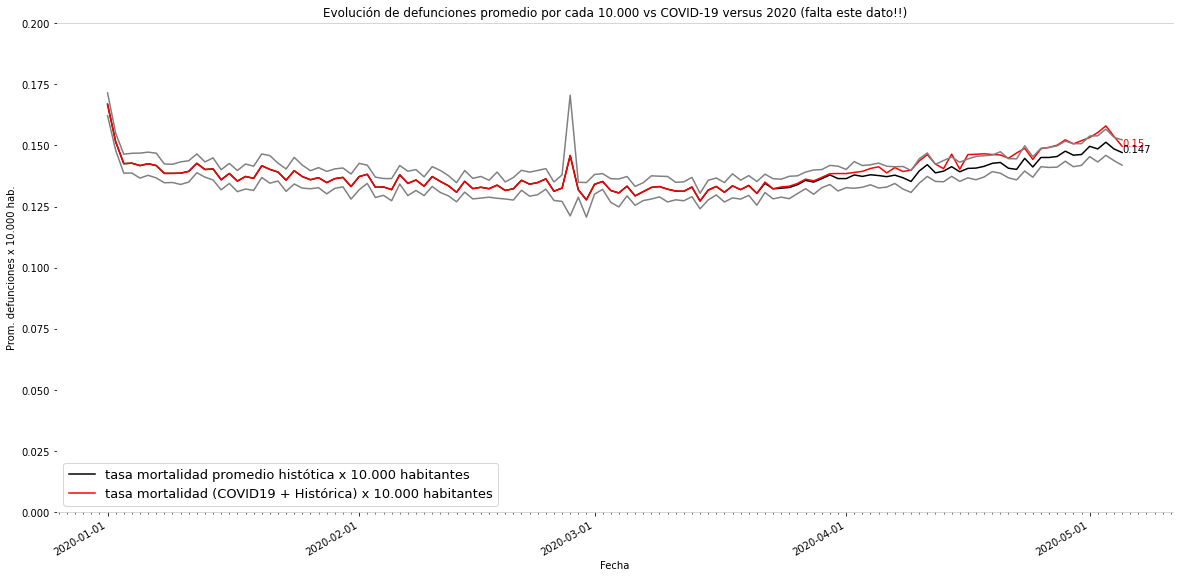

In [208]:
#--------------------------------------------
# GRÁFICO
#--------------------------------------------
# finalmente graficamos con pyplot, sientase libre cualquiera de usar algo más fancy

#Librerías necesarias
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Formateo de datos
months = mdates.MonthLocator()   # every year, decia year
days = mdates.DayLocator()  # every month, decía months
months_fmt = mdates.AutoDateFormatter('%M') # decía years_fmt

#Creamos el dataframe con solo los datos necesarios para el plot
fCovid


#inciamos el gráfico y sus ejes
fig, ax = plt.subplots()
ax.plot('Fecha', 'PromDefX10000', data=fCovid, color='black')
ax.plot('Fecha', 'Covidx10000', data=fCovid, color='red')


#intervalos de confianza 95%
ax.plot('Fecha', 'hi', data=fCovid, color='grey')
ax.plot('Fecha', 'low', data=fCovid, color='grey')

# delimitamos el eje y
ax.set_ylim([0, np.nanmax(fCovid['Covidx10000'].values) + np.nanmax(fCovid['Covidx10000'].values) * 0.2 ])

# formateamos las marcas
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(days)

# formateamos la grilla
ax.grid(False)

# Autoajuste de las etiquetas
fig.autofmt_xdate()

# seteamos leyendas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Prom. defunciones x 10.000 hab.')
ax.set_title('Evolución de defunciones promedio por cada 10.000 vs COVID-19 versus 2020 (falta este dato!!)')

#tamaño del grafico
fig.set_figheight(10)
fig.set_figwidth(20)



# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(('tasa mortalidad promedio histótica x 10.000 habitantes', 'tasa mortalidad (COVID19 + Histórica) x 10.000 habitantes')\
          , loc='lower left', shadow=False, fontsize = 13)


plt.text(fCovid['Fecha'][len(fCovid)-1] , fCovid['Covidx10000'][len(fCovid)-1], round(fCovid['Covidx10000'][len(fCovid)-1], 3), color = 'red')
plt.text(fCovid['Fecha'][len(fCovid)-1] , fCovid['PromDefX10000'][len(fCovid)-1], round(fCovid['PromDefX10000'][len(fCovid)-1], 3), color = 'black')
plt.show()

### ¿Cómo interpretar el gráfico?
La serie de color negro corresponde a las defunciones promedio diaria desde 1990 a 2017 por cada 10.000 habitantes en Chile
La serie roja es una serie compuesta que a partir del primer reporte de COVID-19 emitido oficialmente por el MINSAL comienza a tener data. La combinación es la suma de la serie negra con la serie de defunciones por COVID-19 por cada 10.000 habitantes diarias. Es decir, muestra cuanto ha afectado la tasa de mortalidad promedio, asumiendo que la tasa de mortalidad de aquellos quines fallecieron por razones distintas al COVID-19 sigue la tendencia promedio. Esta suposición la hago dado que por ahora **NO TENGO DATOS DE MORTALIDAD 2020**

Además en gris se pueden ver los límites dle intervalo de confianza de 95% para la serie histórica.

## ¿Por qué es importante este gráfico?

El efecto de la pandemia sobre la tasa de mortalidad nos puede dar luces del impacto de esta enfermedad sobre el sistema de salud, y con ello tomar medidas más estrictas en base a este indicador.
La verdad me sorporendí con los pocos datos que existen sobre mortalidad en el mundo, es difícil encontrar datos, en otros paises sudamericanos, incluso USA, pero en Europa, por suerte, es distinto.
Encontré las cifras de defunciones generales semanales desde 2010 a marzo 2020 de Inglaterra y Gáles, así como sus cifras de defunciones debido a COVID.
Con los datos descritos, ya es posible replicar el análisis, y quiero mostrarles la razón de que sea importante revisar este indicador

https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales

In [1]:
import ssl

In [2]:
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2010/publishedweek2010.xls', "2010.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2011/publishedweek2011.xls', "2011.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2012/publishedweek2012.xls', "2012.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2013/publishedweek2013.xls', "2013.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2014/publishedweek2014.xls', "2014.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2015/publishedweek2015.xls', "2015.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2016/publishedweek522016.xls', "2016.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2017/publishedweek522017.xls', "2017.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2018/publishedweek522018withupdatedrespiratoryrow.xls', "2018.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2019/publishedweek522019.xls', "2019.xls")
urllib.request.urlretrieve('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2020/publishedweek182020.xlsx', "2020.xls")


('2020.xls', <http.client.HTTPMessage at 0x241508f9b08>)

In [3]:
#fuentes de población
#2010 - 2018 England
#https://www.ons.gov.uk/generator?format=xls&uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/timeseries/enpop/pop

#2010 - 2018 Wales
#https://www.ons.gov.uk/generator?format=xls&uri=/peoplepopulationandcommunity/populationandmigration/populationestimates/timeseries/wapop/pop

#proyeccion
#https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationprojections%2fdatasets%2ftablea23principalprojectionenglandandwalespopulationinagegroups%2f2018based/ewpppsumpop18.xls

In [5]:
## dfhist
import pandas as pd
import numpy as np
dfConsol = pd.DataFrame()

for i in range(0,10):
    y = 2010 + i
    xls = pd.ExcelFile(str(y) + '.xls')
    if (y < 2016):
        df = pd.read_excel(xls,'Weekly Figures ' + str(y))
    else:
        df = pd.read_excel(xls,'Weekly figures ' + str(y))
    
    df = df[(df['Contents'] == 'Total deaths, all ages')|(df['Contents'] == 'Week number')]
    df = df.reset_index().T
    df.columns = df.iloc[1]
    df = df[2:]
    df['year'] = y
    dfConsol = dfConsol.append(df)

dfConsol = dfConsol.reset_index()
dfConsol = dfConsol.drop(columns = {'index'})

dfConsol['Total deaths, all ages'] = pd.to_numeric(dfConsol['Total deaths, all ages'], errors='coerce')

pop = pd.DataFrame({'year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],\
                   'pop': [55692500, 56171000, 56567800, 56948200, 57408600, 57885400, 58381300, 58744600, 59115809, 59488102, 59829234]})


dfConsol = dfConsol.merge(pop, how = 'left', left_on='year', right_on='year')
dfConsol['DRx10000'] = dfConsol['Total deaths, all ages'] / dfConsol['pop'] * 10000

dTemp = dfConsol.drop(columns = {'year', 'Total deaths, all ages', 'pop'})
dfWeekHist = dTemp.groupby(['Week number'], as_index = False)['DRx10000'].agg(['mean', 'count', 'std']).reset_index()
dfWeekHist['low'] = dfWeekHist['mean']  - (1.96 * dfWeekHist['std'] / np.sqrt(dfWeekHist['count']))
dfWeekHist['hi'] = dfWeekHist['mean']  + (1.96 * dfWeekHist['std'] / np.sqrt(dfWeekHist['count']))
dfWeekHist = dfWeekHist.drop(columns = {'std', 'count'})

In [6]:
# df2020
xls = pd.ExcelFile('2020.xls')
df2020 = pd.read_excel(xls,'Weekly figures 2020')

df2020 = df2020[(df2020['Contents'] == 'Total deaths, all ages')|(df2020['Contents'] == 'Week number')]
df2020 = df2020.reset_index().T
df2020.columns = df2020.iloc[1]
df2020 = df2020[2:]
df2020['year'] = 2020
df2020 = df2020.dropna()

df2020 = df2020.reset_index()
df2020 = df2020.drop(columns = {'index'})

df2020['Total deaths, all ages'] = pd.to_numeric(df2020['Total deaths, all ages'], errors='coerce')
df2020['pop'] = 59829234
df2020['DR2020x10000'] = df2020['Total deaths, all ages'] / df2020['pop'] * 10000

df2020 = df2020.drop(columns={'Total deaths, all ages', 'year', 'pop'})

In [7]:
#dfCOVID
xls = pd.ExcelFile('2020.xls')
dfCovid = pd.read_excel(xls,'Covid-19 - Weekly registrations')
dfCovid = dfCovid[(dfCovid['Contents'] == 'Deaths involving COVID-19, all ages1')|(dfCovid['Contents'] == 'Week number')]
dfCovid = dfCovid.reset_index().T
dfCovid.columns = dfCovid.iloc[1]
dfCovid = dfCovid[2:]
dfCovid['year'] = 2020
dfCovid = dfCovid.dropna()

dfCovid = dfCovid.reset_index()
dfCovid = dfCovid.drop(columns = {'index'})

dfCovid['Deaths involving COVID-19, all ages1'] = pd.to_numeric(dfCovid['Deaths involving COVID-19, all ages1'], errors='coerce')
dfCovid['pop'] = 59829234
dfCovid['DRCOVIDx10000'] = dfCovid['Deaths involving COVID-19, all ages1'] / dfCovid['pop'] * 10000

dfCovid = dfCovid.drop(columns={'Deaths involving COVID-19, all ages1', 'year', 'pop'})

In [9]:
# Consolidacion
import math

dfEngland = dfCovid.merge(dfWeekHist, how = 'left', left_on = 'Week number', right_on = 'Week number')
dfEngland = dfEngland.merge(df2020, how = 'left', left_on = 'Week number', right_on = 'Week number')
dfEngland['CompCovid'] = dfEngland['DRCOVIDx10000'] + dfEngland['mean']
dfEngland.loc[dfEngland['DRCOVIDx10000'] == 0, 'CompCovid'] = math.nan
dfEngland = dfEngland.drop(columns = {'DRCOVIDx10000'})



dfEngland.index = np.arange(1, len(dfEngland) + 1)

In [10]:
dfEngland['lowCov'] = math.nan
dfEngland.loc[dfEngland['Week number'] > 10, 'lowCov'] = dfEngland['CompCovid'] - (dfEngland['mean'] - dfEngland['low'])

dfEngland['hiCov'] = math.nan
dfEngland.loc[dfEngland['Week number'] > 10, 'hiCov'] = dfEngland['CompCovid'] + (dfEngland['mean'] - dfEngland['low'])

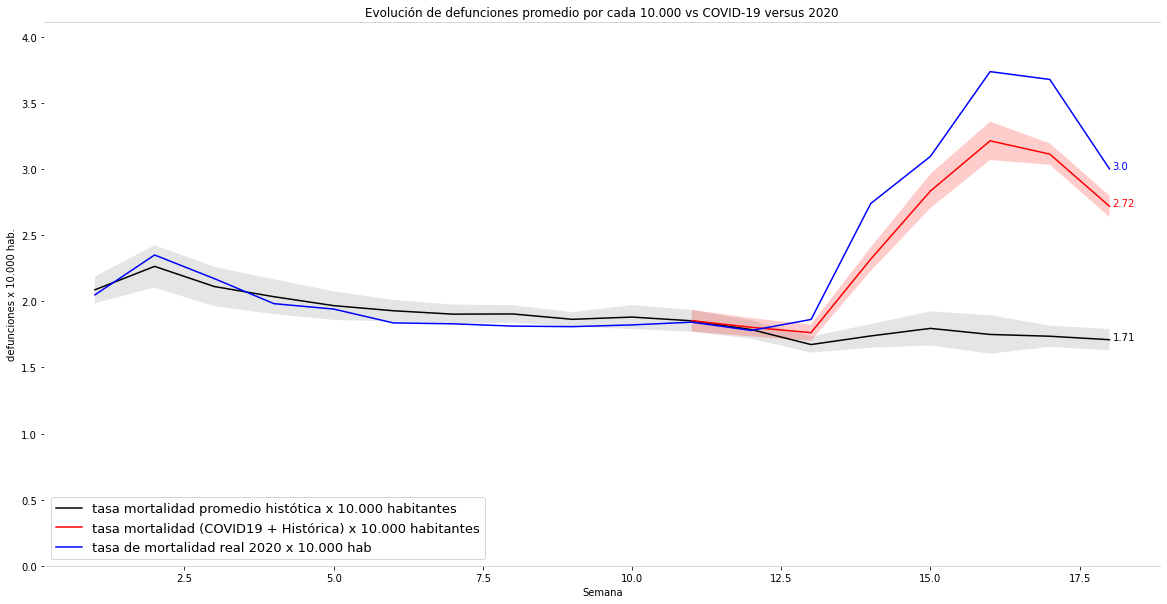

In [11]:
#--------------------------------------------
# GRÁFICO
#--------------------------------------------
# finalmente graficamos con pyplot, sientase libre cualquiera de usar algo más fancy

#Librerías necesarias
import matplotlib.pyplot as plt
import numpy as np

#inciamos el gráfico y sus ejes
fig, ax = plt.subplots()
ax.plot('Week number', 'mean', data=dfEngland, color='black')
ax.plot('Week number', 'CompCovid', data=dfEngland, color='red')
ax.plot('Week number', 'DR2020x10000', data=dfEngland, color='blue')


ax.fill_between(dfEngland.index, dfEngland.low, dfEngland.hi, facecolor='grey', alpha=.2)
ax.fill_between(dfEngland.index, dfEngland.lowCov, dfEngland.hiCov, facecolor='red', alpha=.2)

# delimitamos el eje y
ax.set_ylim([0, np.nanmax(dfEngland['DR2020x10000'].values) + np.nanmax(dfEngland['DR2020x10000'].values) * 0.1 ])


# formateamos la grilla
ax.grid(False)

# seteamos leyendas y título
ax.set_xlabel('Semana')
ax.set_ylabel('defunciones x 10.000 hab.')
ax.set_title('Evolución de defunciones promedio por cada 10.000 vs COVID-19 versus 2020')

#tamaño del grafico
fig.set_figheight(10)
fig.set_figwidth(20)

# color de los ejes 
ax.spines['bottom'].set_color('#cccccc')
ax.spines['top'].set_color('#cccccc') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.legend(('tasa mortalidad promedio histótica x 10.000 habitantes', 'tasa mortalidad (COVID19 + Histórica) x 10.000 habitantes',\
          'tasa de mortalidad real 2020 x 10.000 hab')
          , loc='lower left', shadow=False, fontsize = 13)

plt.text(dfEngland['Week number'][len(dfEngland['Week number'])] + 0.05, dfEngland['DR2020x10000'][len(dfEngland['DR2020x10000'])], round(dfEngland['DR2020x10000'][len(dfEngland['DR2020x10000'])], 2), color = 'blue')
plt.text(dfEngland['Week number'][len(dfEngland['Week number'])] + 0.05, dfEngland['CompCovid'][len(dfEngland['CompCovid'])], round(dfEngland['CompCovid'][len(dfEngland['CompCovid'])], 2), color = 'red')
plt.text(dfEngland['Week number'][len(dfEngland['Week number'])] + 0.05, dfEngland['mean'][len(dfEngland['mean'])], round(dfEngland['mean'][len(dfEngland['mean'])], 2), color = 'black')

plt.show()

In [13]:
import os
cwd = os.getcwd()
for i in range(0,11):
    a = 2010 + i
    os.remove(cwd + '\\' + str(a) + '.xls')

Como se aprecia en el gráfico la diferencia entre la suma de las series COVID + Histórica (linea roja) y defunciones reales 2020, es significativa.
Frente a esto nos surge las dudas:
- ¿A qué se debe esta diferencia?
- ¿Se están contabilizando correctamente las defunciones por COVID?
- ¿El factor COVID ha incidido en la muerte por otras causas?

Y la pregunta principal:
- **¿Está pasando esto en Chile?**

## Algunas descripciones estadísticas de la serie histórica.
En esta sección les presento algunos estadísticos descripitivos de la serie histórica, para demostrar lo estable de la curva de defunciones.

In [172]:
# Calculamos la desviación estándar de cantidad de defunciones por día del año
stdDevYear = agrupDefun.groupby(['MES_DEF','DIA_DEF'])['CANT_FALLECIDOS'].std().reset_index()

# Calculamos el promedio de cantidad de defunciones por día del año
promYear = agrupDefun.groupby(['MES_DEF', 'DIA_DEF'])['CANT_FALLECIDOS'].mean().reset_index()

# Creamos el dataframe con el cálculo del porcentaje que representa la desviación estándar sobre el promedio
Statistitcs = promYear.merge(stdDevYear, how = 'left', left_on = ['MES_DEF', 'DIA_DEF'], right_on = ['MES_DEF', 'DIA_DEF'])
Statistitcs = Statistitcs.rename(columns = {'CANT_FALLECIDOS_x': 'Promedio', 'CANT_FALLECIDOS_y': 'DesvStd'})
Statistitcs['%SD/AVG'] = Statistitcs['DesvStd'] / Statistitcs['Promedio'] * 100
Statistitcs.sort_values(by = ['%SD/AVG'], ascending = False)

Statistitcs['MESDIA'] = Statistitcs['MES_DEF'].map(int).map(str) + '-' + Statistitcs['DIA_DEF'].map(int).map(str)



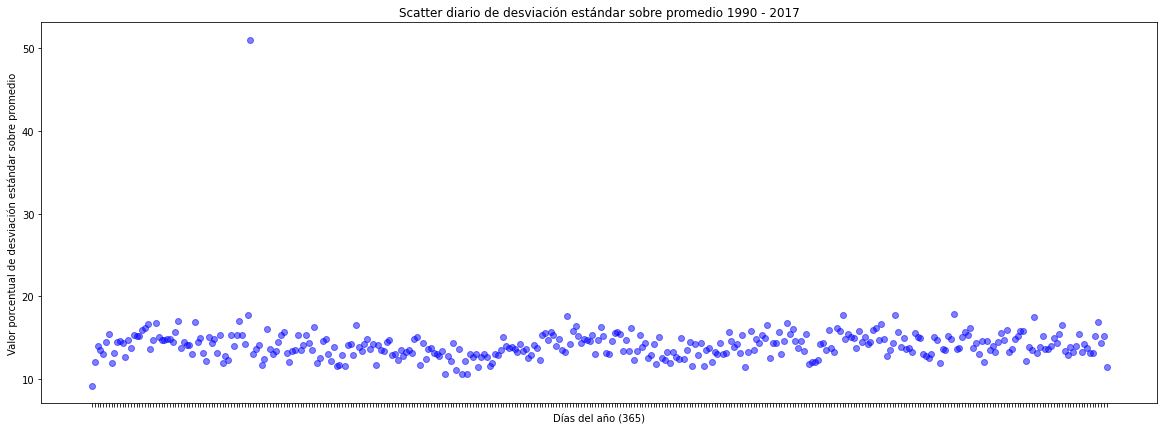

,MES_DEF,DIA_DEF,Promedio,DesvStd,%SD/AVG,MESDIA
57,2.0,27.0,233.964286,119.475546,51.065720,2-27
310,11.0,6.0,225.750000,40.367410,17.881466,11-6
56,2.0,26.0,211.607143,37.641918,17.788586,2-26
270,9.0,27.0,246.142857,43.591296,17.709754,9-27
289,10.0,16.0,233.535714,41.331077,17.697968,10-16
171,6.0,20.0,276.321429,48.684969,17.618962,6-20
339,12.0,5.0,218.785714,38.420054,17.560586,12-5
31,2.0,1.0,218.964286,37.374464,17.068749,2-1
53,2.0,23.0,215.357143,36.663853,17.024675,2-23
37,2.0,7.0,214.642857,36.367684,16.943347,2-7


In [173]:
#-------------
# Graficamos
#-------------
# un simple scatter para ver como se comporta el indicador
fig3, ax3 = plt.subplots()

#usaremos pandas para graficar
ax3.scatter(Statistitcs['MESDIA'], Statistitcs['%SD/AVG'], color='blue', alpha=0.5)

# Settings
fig3.set_figheight(7)
fig3.set_figwidth(20)
ax3.grid(False)
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_xlabel('Días del año (365)')
ax3.set_ylabel('Valor porcentual de desviación estándar sobre promedio')
ax3.set_title('Scatter diario de desviación estándar sobre promedio 1990 - 2017')

# graficamos
plt.show()

# y mostramos el topten de valores
Statistitcs = Statistitcs.sort_values(by = ['%SD/AVG'], ascending = False)
Statistitcs.head(10)

Vemos entonces que se trata de valores con baja variablidad, pues con excepción del 27 de febrero (terremoto + tsunami), el resto de los días tiene valores bajo el 18% de SD/AVG, por lo tanto, esos valores debieran dar una idea cercana a las defunciones que hubieran ocurrido sin COVID-19
De todas maneras podemos verlo en el siguiente boxplot.

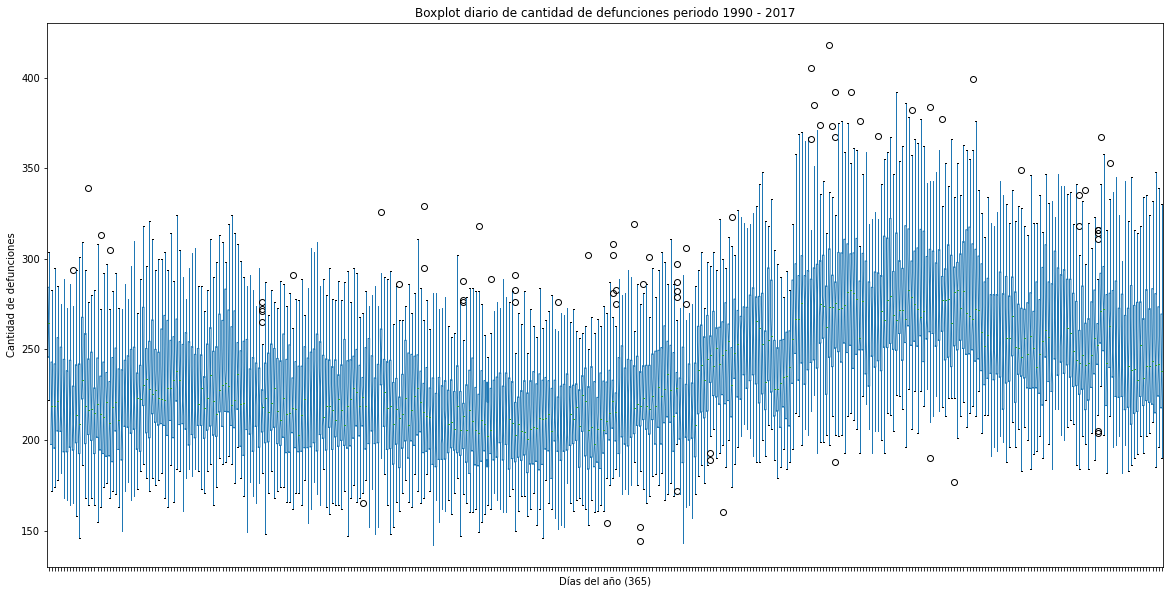

In [174]:
import re as r
# tabajamos sobre el dataframe que contiene los datos históricos por día mes y año
bplotDF = agrupDefun.copy()

#creamos un campo que tenga el mes y dia concatenados
bplotDF['mesdia'] = bplotDF['MES_DEF'].map(int).map(str) + '-' + bplotDF['DIA_DEF'].map(int).map(str)

# eliminamos los campos innecesarios
bplotDF = bplotDF[['ANO_DEF', 'mesdia', 'CANT_FALLECIDOS']]

#pivoteamos sobre el campo año y mesdia
pivotPlot = pd.pivot_table(bplotDF, values = ['CANT_FALLECIDOS'], index = ['ANO_DEF'], columns = ['mesdia'], aggfunc=np.sum)

#limpiamos y dejamos las columnas como dato único y no como tupla
pivotPlot.columns = [ '_'.join(x) for x in pivotPlot.columns ]
pivotPlot.reset_index(inplace=True)
pivotPlot = pivotPlot.rename(columns=lambda x: r.sub('CANT_FALLECIDOS_','',x))
pivotPlot = pivotPlot.drop(columns = {'ANO_DEF'})

#--------------------
#    Graficamos
#--------------------

#creamos el gráfico
fig2, ax2 = plt.subplots()

#usaremos pandas para graficar
pivotPlot.boxplot(ax=ax2, notch=True, bootstrap=5000)

# Settings
fig2.set_figheight(10)
fig2.set_figwidth(20)
ax2.set_ylim([130, 430])
ax2.grid(False)
ax2.xaxis.set_major_formatter(plt.NullFormatter()) 
ax2.set_xlabel('Días del año (365)')
ax2.set_ylabel('Cantidad de defunciones')
ax2.set_title('Boxplot diario de cantidad de defunciones periodo 1990 - 2017')

# presentación
plt.show()


Finalmente vemos gráficamente un boxplot para cada día del año del periodo 1990-2017 y como se puede apreciar las varianzas son bajas en relacion a la magnitud de cada promedio, por lo que la estimación que se está haciendo usando el promedio diario, para proyectar defunciones en este año, debiera sera bastante cercana a la realidad